<h1><center>Mineração Estatística de Dados</center></h1>

<h2><center>Projeto 3: Seleção e transformação de atributos, avaliação de classificadores</center></h2>
<br>
<br>
<br>


<h2><center>Bruno Gomes Coelho - 9791160</center></h2>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Imports e ler os dados

In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score

# Models
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)
from sklearn.feature_selection import chi2, RFE, SelectKBest

# Processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split


TESTING = False
SIZE = (12, 9)
K_FOLDS = 10
N_SIMUL = 3

if TESTING:
    K_FOLDS = 3
    N_SIMUL = 1

clfs = {"knn": KNeighborsClassifier, "RF": RandomForestClassifier, 
       "MLP": MLPClassifier, "NB": GaussianNB}



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q1

**Considere a base dados gerado pela função ,  `skdata.make_circles(noise = 0.2)` conforme feito em aula.**


**Compare os seguintes algoritmos: (a) Redes Neurais, (b) Naive Bayes, (c) Knn, (d) Random forest. Use as métricas Accuracy, F1, Precision, Recall.Useo método k-fold cross validation com k = 10.**

In [2]:
x, y = make_circles(noise = 0.2)

In [3]:
%%capture 

scoring = ["accuracy", "f1", "precision", "recall"]
scores = {name: pd.DataFrame() for name in scoring}

for _ in range(N_SIMUL):
    for name, clf in clfs.items():
        results = cross_validate(clf(), x, y, scoring=scoring, cv=K_FOLDS)

        for metric_name, metric_results in results.items():
            if "test" not in metric_name:
                continue
            temp_df = scores[metric_name[5:]]
            temp_df = temp_df.append([x for x in zip([name]*K_FOLDS, metric_results)])
            scores[metric_name[5:]] = temp_df

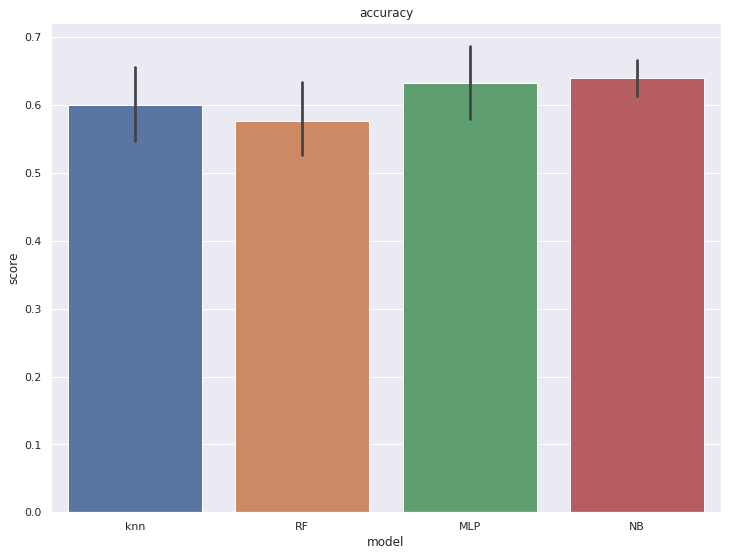

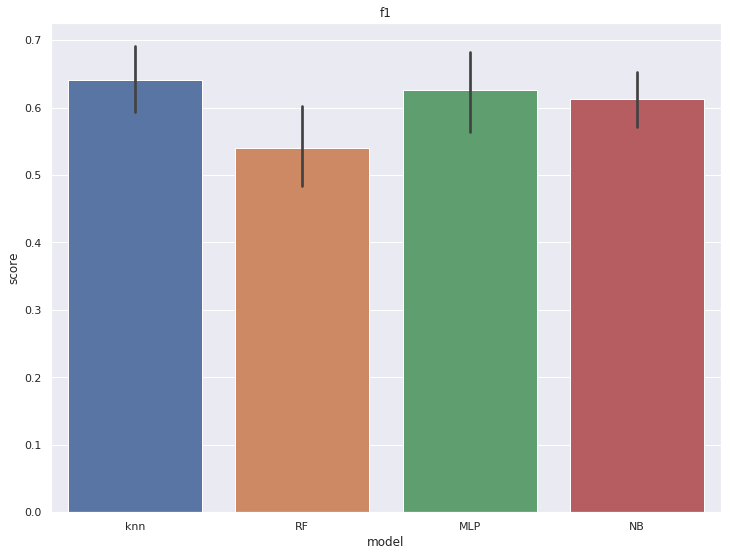

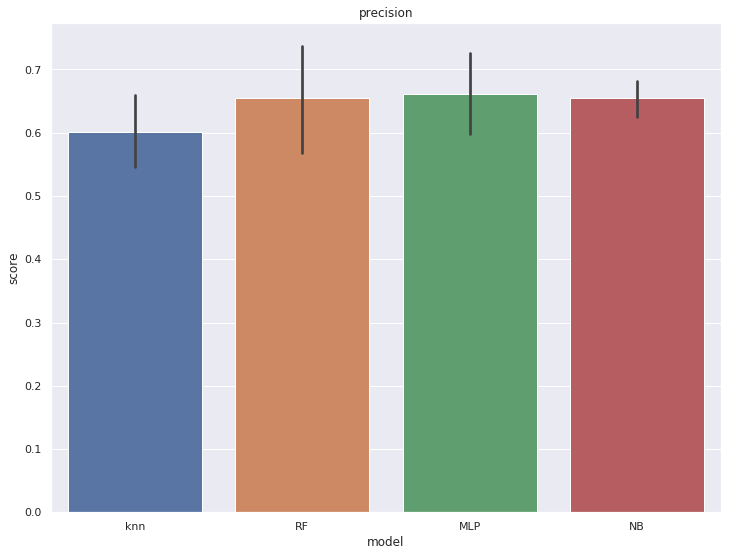

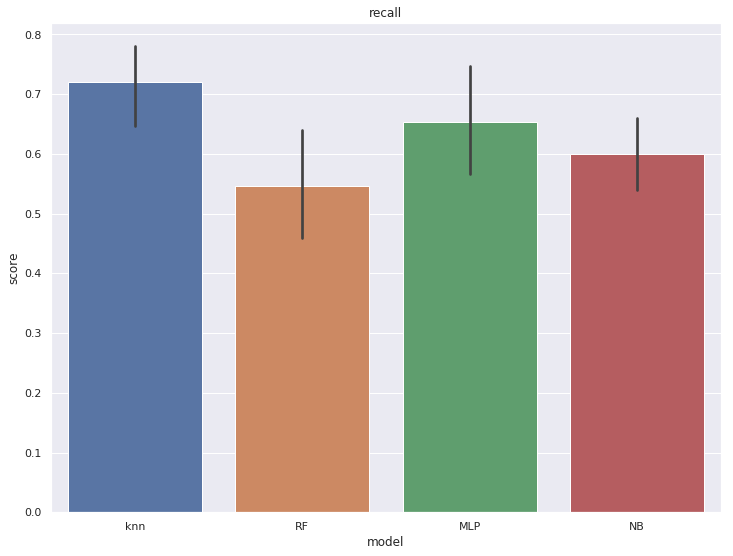

In [4]:
for metric_name, df_metric in scores.items():
    df_metric.columns = ["model", "score"]
    plt.figure(figsize=SIZE)
    sns.barplot(data=df_metric, y="score", x="model")
    plt.title(metric_name)
    plt.show();

Considerando a métrica F1, que leva em cosnideração tanto a precisão como o recall de uma classificação, podemos considerar tando o K-NN, a MLP e o NB como os três melhores classificadores, pois todos obtiveram um resultado bem próximos, embora o K-NN obteve a maior média.

Dependendo do nosso problema e portanto da(s) métrica(s) que mais nos importam, podemos chegar a conclusões diferentes:

Por exemplo, se estamos interessados em um recall alto, o K-NN obteve o melhor resultado;

Se estissemos preocupados com precisão, valeria a pena utilizar outra medida como desampate uma vez que tanto a RF, a MLP e o NB obtiveram resultados parecidos;

E se estivessemos analisando apenas a acurácia, tanto a MLP como o NB poderiam ser considerados bons classificadores.

Com isso, percebemos a importância de se escolher uma métrica que reflita no aspecto  importante do problema/*bussiness*.



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Considerea partir de agoraa base de dados sobre diabetes: https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [5]:
df = pd.read_csv("diabetes.csv")
if TESTING:
    df = df.sample(n=100)
    
x = df.drop(columns=["Outcome"])
y = df["Outcome"]

Vamos normalizar os dados entre [0, 1] uma vez que o PCA e a rede neural são sensíveis a escala das features;

Além disso temos que manter eles positivos para funcionarem com o chi squared teste.


In [6]:
x = MinMaxScaler().fit_transform(x)

# Q2

**Verifique como a classifição muda quando consideramos o método k-fold cross validation. Ou seja, faça um gráfico da medida Precison em função de k para os algoritmos Redes Neurais e Random Forest**

In [7]:
%%capture 
models = ["RF", "MLP"]
scores = pd.DataFrame(columns=["K", "model", "precision"])

k_search_space = range(2, 4) if TESTING else range(2, 15)

for _ in range(N_SIMUL):
    for k_folds in k_search_space:
        for name, clf in clfs.items():
            if name not in models:
                continue
            results = cross_validate(clf(), x, y, scoring="precision", cv=k_folds)
            for num in results["test_score"]:
                scores.loc[len(scores)] = [k_folds, name, num]

Text(0.5, 1.0, 'Precisão em função no números de K folds')

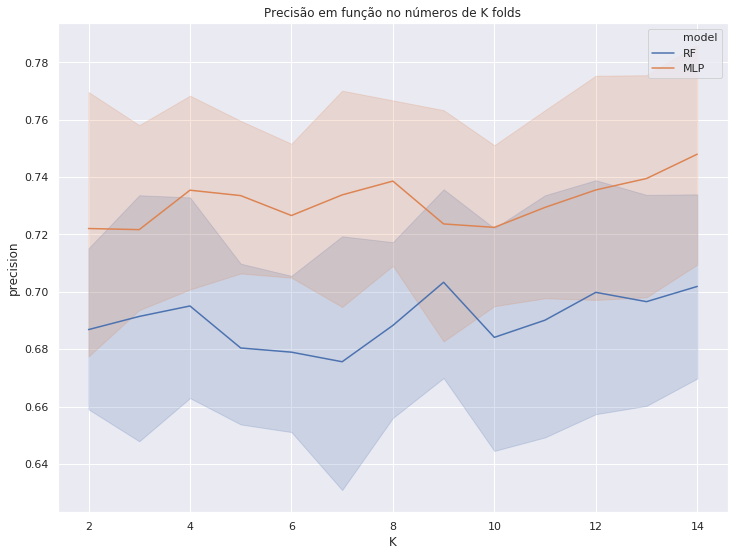

In [8]:
plt.figure(figsize=SIZE)
sns.lineplot(data=scores, x="K", y="precision", hue="model");
plt.title("Precisão em função no números de K folds")

Conforme o gráfico acima, podemos perceber que a MLP obteve um resultado sempre melhor que a RF;

Ainda mais, percebemos que em geral conforme aumentamos o número K de folds utilzados no k_folds, maior a precisão obtida - isso pode talvez ser explicado pela maior quantidade de dados utilizados.

Porém, em ambos os casos parece também que utilizar de 8 a 10 folds já nos da resultados bons o suficiente.



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q3

**Compare os classificadores Redes Neurais, Naive Bayes e Random Forest para k=10 (k-fold cross validation estratificado) em termos da curva ROC. Qual classificador é o melhor? Justifique.**

In [9]:
%%capture
models = ["RF", "MLP", "NB"]
scores = pd.DataFrame(columns=["model", "ROC"])

for _ in range(N_SIMUL):
    for name, clf in clfs.items():
        if name not in models:
            continue
        results = cross_validate(clf(), x, y, scoring="roc_auc", cv=K_FOLDS)
        for num in results["test_score"]:
            scores.loc[len(scores)] = [name, num]

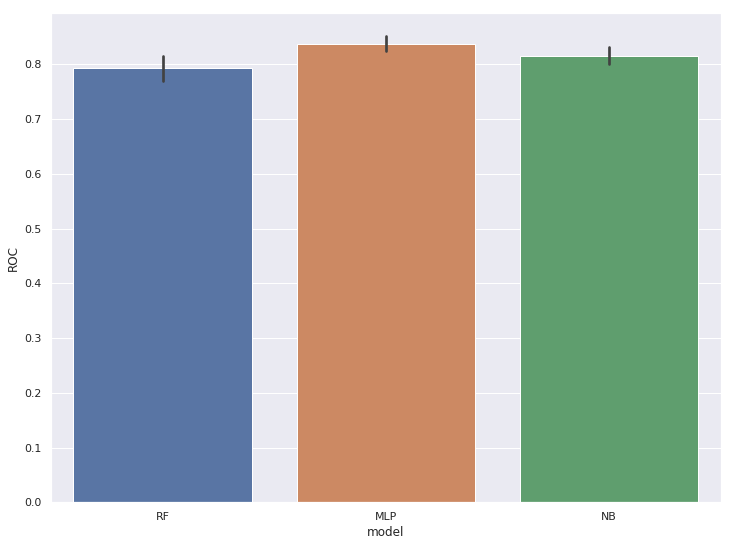

In [10]:
plt.figure(figsize=SIZE)
sns.barplot(data=scores, y="ROC", x="model");

Considerando os 3 classificadores mencionados e a área sobre a curva ROC como medida, podemos considerar a MLP como o melhor classificador dos 3, por ter sua média mais alta e um desvio padrão relativamente baixo.



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q4

**Usando o método que seleciona apenas um atributo por vez (univariado, teste qui-quadrado), faça uma curva da medida F1 em função do número de atributos considerados. Isto é, obtenha F1 para o atributo mais importante, depois para os dois mais importantes e assim por diante**

In [11]:
%%capture
models = ["RF", "MLP", "NB"]
scores = pd.DataFrame(columns=["model", "F1", "Numero features"])

for _ in range(N_SIMUL):
    for n_features in range(1, x.shape[1]+1):
        selector = SelectKBest(score_func=chi2, k=n_features)
        selector.fit(x, y)
        selected_x = selector.transform(x)

        for name, clf in clfs.items():
            results = cross_validate(clf(), selected_x, y, scoring="f1", cv=K_FOLDS)
            for num in results["test_score"]:
                scores.loc[len(scores)] = [name, num, n_features]

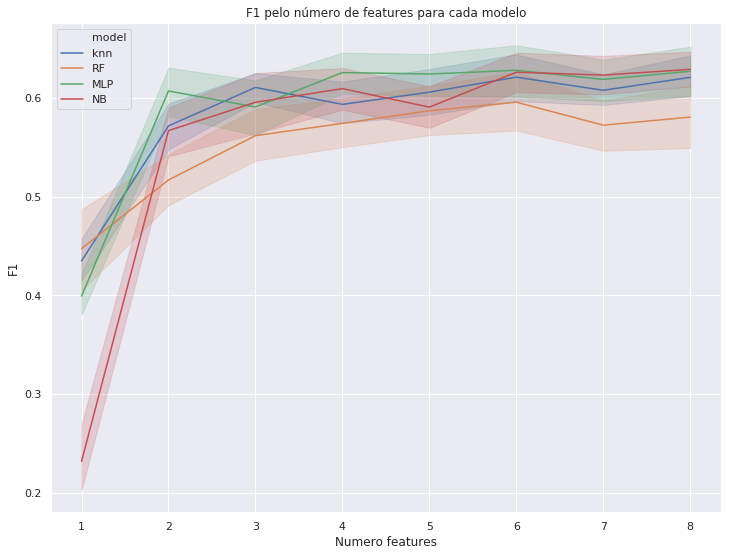

In [12]:
plt.figure(figsize=SIZE)
sns.lineplot(data=scores, y="F1", x="Numero features", hue="model")
plt.title("F1 pelo número de features para cada modelo");

Conforme podemos observar pelo gŕafico acima, dos 4 classificadores o NB foi o que se mostrou mais sensível a uma quantidade baixa de features, tento um resultado muito a baixo dos outros algoritmos quando considerando apenas 1 feature;

Fora esse caso, a RF se mostrou o pior de todos os algoritmos, quase sempre se mantendo abaixo dos outros independente da quantidade de features utilizadas;

Ainda mais percebemos que um número de 6 features já parece ser o suficiente para alcançar o resultado das 8 features originais, mostrando que possivelmente poderiamos desconsiderar 2 das features envolvidas.



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q5

**Projete os dados usando PCA e faça um gráfico de F1 em termos do número de components. Quantos components oferecem a maior taxa de acerto? Compare com a curva “cumulative explained variance” versus “number of components” e explique os resultados.**

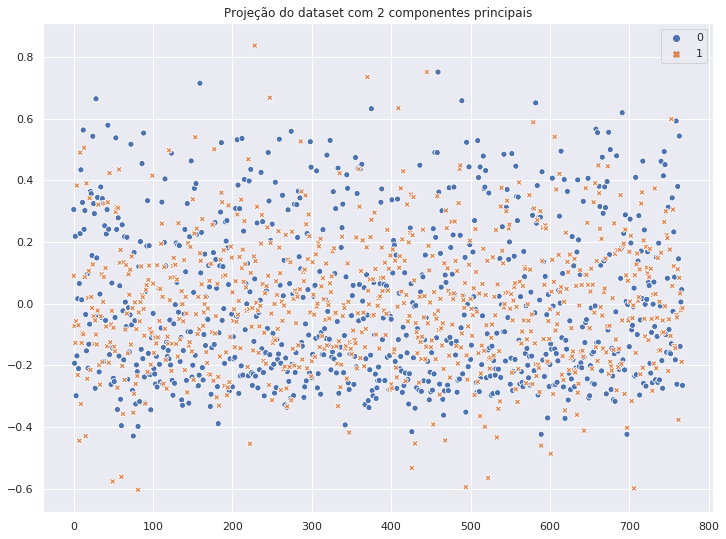

In [13]:
pca_x = PCA(n_components=2).fit_transform(x)
plt.figure(figsize=SIZE)
sns.scatterplot(data=pca_x, hue=y)
plt.title("Projeção do dataset com 2 componentes principais");

In [14]:
%%capture
models = ["RF", "MLP", "NB"]
scores = pd.DataFrame(columns=["model", "F1", "Numero componentes"])

for n_component in range(1, x.shape[1]+1):
    pca = PCA(n_components=n_component).fit(x)
    pca_x = pca.transform(x)
    
    for name, clf in clfs.items():
        results = cross_validate(clf(), pca_x, y, scoring="f1", cv=K_FOLDS)
        for num in results["test_score"]:
            scores.loc[len(scores)] = [name, num, n_component]

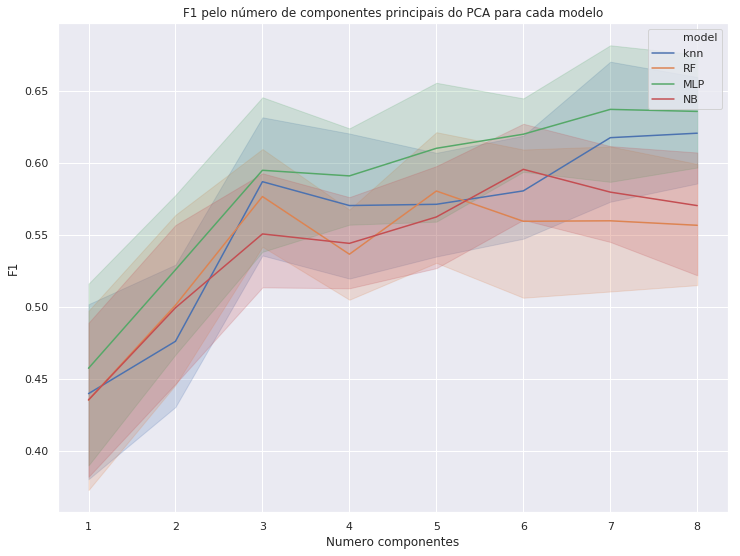

In [15]:
plt.figure(figsize=SIZE)
sns.lineplot(data=scores, y="F1", x="Numero componentes", hue="model")
plt.title("F1 pelo número de componentes principais do PCA para cada modelo");

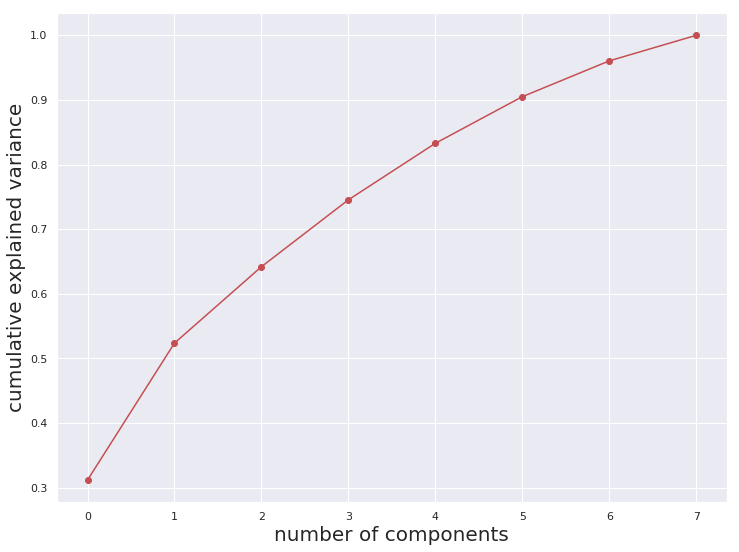

In [16]:
plt.figure(figsize=SIZE)
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.xlabel('number of components', fontsize=20)
plt.ylabel('cumulative explained variance', fontsize=20);

Podemos observar, como esperado, que em geral conforme aumentamos o número de componentes do PCA, maior nossa medida de classificação, F1.

Em geral, para valores menores ou iguais a 3 componentes, obtemos resultados muito instáveis ou insastifatórios para a redução de dimensionalidade valer a pena;

Para os algoritmos NB e RF, o ideal parece ser usar entre 5 a 6 das 8 features originais;

Já para o K-NN e a MLP, é possível observar que conforme mais features originais utilizamos, melhor os resultados, até o total de todas as 8 features.



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q6

**Considereagoraa base de dados do Titanic, conforme descrita em: https://www.kaggle.com/c/titanic/data. Construa a curva ROC para as redes neurais e random forest.**

**Identifique os atributos mais importantes usando o método wrapper. Construa um gráfico da medida Precision em função do número de atributos usados. É possível melhorar a classificação considerando um número reduzido de atributos?**

In [17]:
df = pd.read_csv("titanic.csv")
if TESTING:
    df = df.sample(n=100)

# Vamos remover o "PassengerId" pois é uma coluna ID
df.drop(columns="PassengerId", inplace=True)

# Remove nulos e encoda variavéis categóricas
df["Cabin"] = df["Cabin"].astype(str)
df.fillna({"Age": -1, "Cabin": "NaN", "Embarked": "NaN"}, inplace=True)
for cat_col in ["Name", "Sex", "Cabin", "Embarked", "Ticket"]:
    df[cat_col] = LabelEncoder().fit_transform(df[cat_col])
    
    
x = df.drop(columns=["Survived"])
y = df["Survived"]

Curva ROC padrão

In [18]:
%%capture --no-stdout --no-display
models = ["RF", "MLP"]
results = defaultdict(list)

x_train, x_test, y_train, y_test = train_test_split(x, y)
for name, clf in clfs.items():
    if name not in models:
        continue
    y_preds = clf().fit(x_train, y_train).predict(x_test)
    results[name].append(("Padrão", *roc_curve(y_test, y_preds)))

In [19]:
%%capture --no-stdout --no-display
models = ["RF", "MLP"]

rfe = RFE(RandomForestClassifier(), 1).fit(x_train, y_train)

for name, clf in clfs.items():
    if name not in models:
        continue
    for n_features in range(1, x.shape[1]):
        feats = [x-1 for x  in rfe.ranking_ if x <= n_features]
        y_preds = clf().fit(x_train.iloc[:, feats], y_train).\
                        predict_proba(x_test.iloc[:, feats])[:, 1]
        results[name].append((n_features, *roc_curve(y_test, y_preds)))


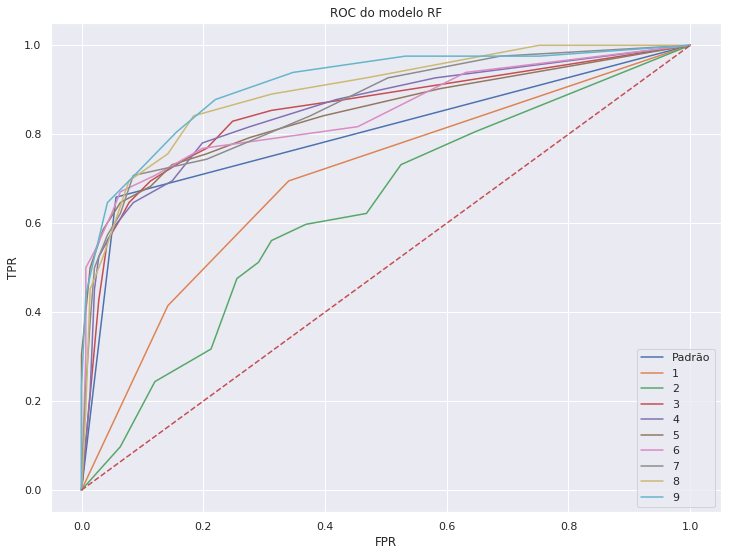

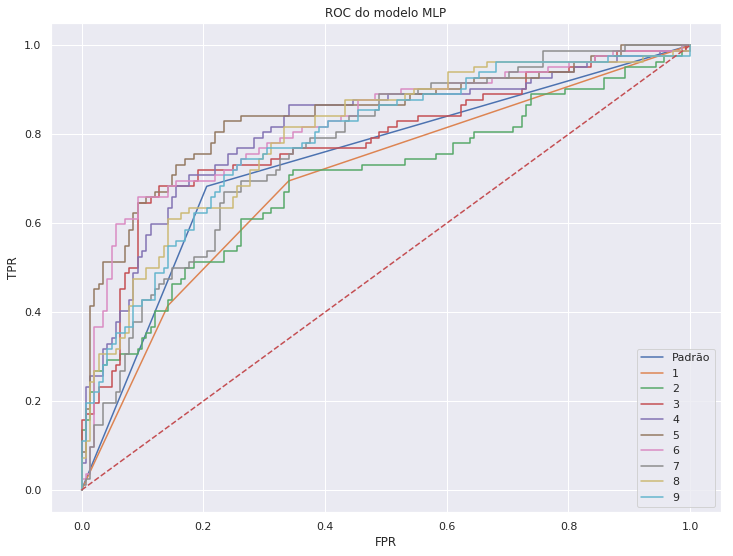

In [20]:
for model_name, model_results in results.items():
    plt.figure(figsize=SIZE)
    plt.title(f"ROC do modelo {model_name}")
    for n_features, fpr, tpr, threshold in model_results:
        plt.plot(fpr, tpr, label=n_features)

    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()

Conforme observado acima, para os 2 modelos investigados (RF e MLP) é possível obter um resultado melhor que o padrão diminuindo a quantidade de features utilizadas;

No caso da RF, apenas utilizar 1 ou 2 features se mostrou claramente pior do que utilizar mais features; Porém em geral qualquer número maior que 3 features se mostrou melhor que o padrão de utilizar todas as 10 features.

No caso da MLP, obtivermos um resultado semelhante, porém mais difícil de analisar - as regiões da curva ROC se cruzam múltiplas vezes, podemos perceber que em geral qualquer número diferente que 1 ou 2 features originais parece ser melhor que utilizar todas as 10 features. Ainda mais percebemos que não temos separações tão contínuas, talvez pela arquitetura utilizada ou pela falta de convergência do algoritmo.


